### Create Dataset From CSV and Folders

In [1]:
import os
import glob
from dotenv import load_dotenv
import torch
import math
import shutil

from tqdm import tqdm
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.document_loaders import CSVLoader, TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders.generic import GenericLoader
from langchain_community.document_loaders import DirectoryLoader


def main():
    """
    Main function to load Verilog and CSV data, create local embeddings, 
    and save a specific FAISS index.
    """
    # --- 1. Load Environment Variables ---
    load_dotenv()

    # --- 2. Define Paths ---
    DATASET_PATH = "../data/verilog_datasets"
    INDEX_PATH = os.path.join(DATASET_PATH, "faiss_qft_verieval")
    QFT_FOLDER_PATH = "../examples/verilog_designs/qft"
    VERILOGEVAL_CSV_PATH = os.path.join(DATASET_PATH, "verilogeval-v2.csv")


    # --- 3. Clean up old database directory ---
    if os.path.exists(INDEX_PATH):
        print(f"--- Deleting old FAISS index directory: '{INDEX_PATH}' ---")
        try:
            shutil.rmtree(INDEX_PATH)
        except OSError as e:
            print(f"Error deleting directory {INDEX_PATH}: {e.strerror}")
            print("Please ensure no other programs are using this directory.")
            return
    print("--- Starting with a fresh index directory. ---")

    # --- 4. Load Documents ---
    all_docs = []
    
    # Load Verilog and Verilog Header files from the qft_pipelined directory
    print(f"\n--- Loading Verilog documents from '{QFT_FOLDER_PATH}' ---")
    if not os.path.exists(QFT_FOLDER_PATH):
        print(f"ERROR: QFT directory not found at '{QFT_FOLDER_PATH}'")
    else:
        # Load Verilog files as plain text, as the LanguageParser does not support Verilog
        loader_verilog = DirectoryLoader(
            QFT_FOLDER_PATH,
            glob=["**/*.v", "**/*.vh"], # UPDATED: Include .vh files
            loader_cls=TextLoader
        )
        verilog_docs = loader_verilog.load()
        all_docs.extend(verilog_docs)
        print(f"Successfully loaded {len(verilog_docs)} Verilog (.v & .vh) files.")

    # Load the specific CSV file
    print(f"\n--- Loading documents from '{VERILOGEVAL_CSV_PATH}' ---")
    if not os.path.exists(VERILOGEVAL_CSV_PATH):
        print(f"ERROR: CSV file not found at '{VERILOGEVAL_CSV_PATH}'")
    else:
        loader_csv = CSVLoader(
            file_path=VERILOGEVAL_CSV_PATH,
            source_column="instruction",
            csv_args={'delimiter': ',', 'quotechar': '"'}
        )
        try:
            csv_docs = loader_csv.load()
            all_docs.extend(csv_docs)
            print(f"Successfully loaded content from {len(csv_docs)} rows in the CSV.")
        except Exception as e:
            print(f"    - ERROR loading file {VERILOGEVAL_CSV_PATH}: {e}")

    if not all_docs:
        print("\nNo documents were loaded. Exiting.")
        return
    print(f"\nTotal documents loaded: {len(all_docs)}.")

    # --- 5. Split Documents into Chunks ---
    print("\n--- Splitting documents into smaller chunks ---")
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=200)
    chunked_docs = text_splitter.split_documents(all_docs)
    print(f"Split the documents into {len(chunked_docs)} chunks.")

    # --- 6. Create Embeddings and Persist to FAISS ---
    print("\n--- Creating local embeddings and building FAISS index ---")
    
    try:
        embeddings = HuggingFaceEmbeddings(
            model_name='all-MiniLM-L6-v2',
            model_kwargs={'device': 'cuda' if torch.cuda.is_available() else 'cpu'}
        )
        print(f"Embedding model loaded onto {'GPU' if torch.cuda.is_available() else 'CPU'}.")

        # --- ROBUST, TWO-STAGE INITIALIZATION FOR FAISS ---
        batch_size = 1024
        if not chunked_docs:
            print("No chunks to process. Exiting.")
            return

        # Stage 1: Initialize the vector store with the first batch.
        print("Initializing FAISS index with the first batch...")
        first_batch = chunked_docs[:batch_size]
        vectorstore = FAISS.from_documents(documents=first_batch, embedding=embeddings)

        # Stage 2: Add the rest in batches with a progress bar.
        remaining_chunks = chunked_docs[batch_size:]
        num_batches = math.ceil(len(remaining_chunks) / batch_size)
        for i in tqdm(range(num_batches), desc="Embedding and Storing in FAISS"):
            start = i * batch_size
            end = start + batch_size
            batch = remaining_chunks[start:end]
            if batch:
                vectorstore.add_documents(batch)
            
        print("\nSuccessfully created and populated FAISS index.")

    except Exception as e:
        print(f"\nAN UNEXPECTED ERROR OCCURRED: {e}")
        return

    # --- 7. Save Final Index ---
    print("\n--- Saving final FAISS index to disk ---")
    vectorstore.save_local(INDEX_PATH)
    print(f"FAISS index is stored in the folder: '{os.path.abspath(INDEX_PATH)}'")

if __name__ == "__main__":
    main()


--- Starting with a fresh index directory. ---

--- Loading Verilog documents from '../examples/verilog_designs/qft' ---
Successfully loaded 51 Verilog (.v & .vh) files.

--- Loading documents from '../data/verilog_datasets/verilogeval-v2.csv' ---
Successfully loaded content from 156 rows in the CSV.

Total documents loaded: 207.

--- Splitting documents into smaller chunks ---
Split the documents into 796 chunks.

--- Creating local embeddings and building FAISS index ---


/home/irman/anaconda3/envs/chipster_D/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Embedding model loaded onto GPU.
Initializing FAISS index with the first batch...


Embedding and Storing in FAISS: 0it [00:00, ?it/s]


Successfully created and populated FAISS index.

--- Saving final FAISS index to disk ---
FAISS index is stored in the folder: '/home/irman/Chipster/data/verilog_datasets/faiss_qft_verieval'


In [2]:
import os
import glob
from dotenv import load_dotenv
import torch
import math
import shutil

from tqdm import tqdm
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import DirectoryLoader


def main():
    """
    Main function to load PySpice, AMS, and RF data, create local embeddings,
    and save a specific FAISS index.
    """
    # --- 1. Load Environment Variables ---
    load_dotenv()

    # --- 2. Define Paths ---
    ANALOG_DATASET_PATH = "../data/analog_datasets"
    SOURCE_DATA_PATH = os.path.join(ANALOG_DATASET_PATH, "AMS_RF_Dataset")
    INDEX_PATH = os.path.join(ANALOG_DATASET_PATH, "faiss_pyspice_ams_rf")


    # --- 3. Clean up old database directory ---
    if os.path.exists(INDEX_PATH):
        print(f"--- Deleting old FAISS index directory: '{INDEX_PATH}' ---")
        try:
            shutil.rmtree(INDEX_PATH)
        except OSError as e:
            print(f"Error deleting directory {INDEX_PATH}: {e.strerror}")
            print("Please ensure no other programs are using this directory.")
            return
    print("--- Starting with a fresh index directory. ---")

    # --- 4. Load Documents ---
    all_docs = []
    
    # Load Python and Markdown files from the pyspice_datasets directory
    print(f"\n--- Loading documents from '{SOURCE_DATA_PATH}' ---")
    if not os.path.exists(SOURCE_DATA_PATH):
        print(f"ERROR: Source data directory not found at '{SOURCE_DATA_PATH}'")
        return
        
    # Load .py and .md files as plain text
    loader_pyspice = DirectoryLoader(
        SOURCE_DATA_PATH,
        glob=["**/*.py", "**/*.md"], # Load Python and Markdown files
        loader_cls=TextLoader
    )
    pyspice_docs = loader_pyspice.load()
    all_docs.extend(pyspice_docs)
    print(f"Successfully loaded {len(pyspice_docs)} source files (.py & .md).")

    if not all_docs:
        print("\nNo documents were loaded. Exiting.")
        return
    print(f"\nTotal documents loaded: {len(all_docs)}.")

    # --- 5. Split Documents into Chunks ---
    print("\n--- Splitting documents into smaller chunks ---")
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=200)
    chunked_docs = text_splitter.split_documents(all_docs)
    print(f"Split the documents into {len(chunked_docs)} chunks.")

    # --- 6. Create Embeddings and Persist to FAISS ---
    print("\n--- Creating local embeddings and building FAISS index ---")
    
    try:
        embeddings = HuggingFaceEmbeddings(
            model_name='all-MiniLM-L6-v2',
            model_kwargs={'device': 'cuda' if torch.cuda.is_available() else 'cpu'}
        )
        print(f"Embedding model loaded onto {'GPU' if torch.cuda.is_available() else 'CPU'}.")

        # --- ROBUST, TWO-STAGE INITIALIZATION FOR FAISS ---
        batch_size = 1024
        if not chunked_docs:
            print("No chunks to process. Exiting.")
            return

        # Stage 1: Initialize the vector store with the first batch.
        print("Initializing FAISS index with the first batch...")
        first_batch = chunked_docs[:batch_size]
        vectorstore = FAISS.from_documents(documents=first_batch, embedding=embeddings)

        # Stage 2: Add the rest in batches with a progress bar.
        remaining_chunks = chunked_docs[batch_size:]
        num_batches = math.ceil(len(remaining_chunks) / batch_size)
        for i in tqdm(range(num_batches), desc="Embedding and Storing in FAISS"):
            start = i * batch_size
            end = start + batch_size
            batch = remaining_chunks[start:end]
            if batch:
                vectorstore.add_documents(batch)
            
        print("\nSuccessfully created and populated FAISS index.")

    except Exception as e:
        print(f"\nAN UNEXPECTED ERROR OCCURRED: {e}")
        return

    # --- 7. Save Final Index ---
    print("\n--- Saving final FAISS index to disk ---")
    vectorstore.save_local(INDEX_PATH)
    print(f"FAISS index is stored in the folder: '{os.path.abspath(INDEX_PATH)}'")

if __name__ == "__main__":
    main()

--- Starting with a fresh index directory. ---

--- Loading documents from '../data/analog_datasets/AMS_RF_Dataset' ---
Successfully loaded 43 source files (.py & .md).

Total documents loaded: 43.

--- Splitting documents into smaller chunks ---
Split the documents into 210 chunks.

--- Creating local embeddings and building FAISS index ---
Embedding model loaded onto GPU.
Initializing FAISS index with the first batch...


Embedding and Storing in FAISS: 0it [00:00, ?it/s]


Successfully created and populated FAISS index.

--- Saving final FAISS index to disk ---
FAISS index is stored in the folder: '/home/irman/Chipster/data/analog_datasets/faiss_pyspice_ams_rf'


### Create Dataset From Website

In [ ]:
import asyncio
import nest_asyncio
import os
import shutil
import math
from tqdm import tqdm
import torch
from urllib.parse import urljoin
import requests
from bs4 import BeautifulSoup

from crawl4ai import AsyncWebCrawler
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS

async def main():
    """
    Main function to crawl the entire Lcapy documentation and create a FAISS index.
    """
    # --- 1. Define Configuration ---
    START_URL = "https://lcapy.readthedocs.io/en/latest/"
    TOC_LINK_SELECTOR = ".toctree-wrapper a"
    INDEX_PATH = "faiss_index_lcapy_docs"

    # --- 2. Clean up old index directory ---
    if os.path.exists(INDEX_PATH):
        print(f"--- Deleting old FAISS index directory: '{INDEX_PATH}' ---")
        shutil.rmtree(INDEX_PATH)
    print("--- Starting with a fresh index directory. ---")

    # --- 3. Discover all URLs using Requests and BeautifulSoup ---
    print(f"\n--- Step 1: Discovering all documentation URLs from '{START_URL}' ---")
    urls_to_crawl = [START_URL] # Always include the main page
    try:
        response = requests.get(START_URL)
        response.raise_for_status() # Will raise an error for bad status codes
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Find all link elements (<a>) that match the CSS selector
        links = soup.select(TOC_LINK_SELECTOR)
        
        for link in links:
            href = link.get('href')
            if href:
                # Convert relative links (e.g., 'netlists.html') to full URLs
                full_url = urljoin(START_URL, href)
                if full_url not in urls_to_crawl:
                    urls_to_crawl.append(full_url)
        
        print(f"Found {len(urls_to_crawl)} total pages to crawl.")

    except Exception as e:
        print(f"\nAN ERROR OCCURRED DURING URL DISCOVERY: {e}")
        return

    # --- 4. Crawl each discovered URL using crawl4ai ---
    print("\n--- Step 2: Crawling each page individually ---")
    all_docs = []
    try:
        async with AsyncWebCrawler() as crawler:
            # Use tqdm to show a progress bar for the crawling step
            for url in tqdm(urls_to_crawl, desc="Crawling Pages"):
                result = await crawler.arun(url=url)
                if result and result.markdown:
                    doc = Document(page_content=result.markdown, metadata={"source": result.url})
                    all_docs.append(doc)
    
        if not all_docs:
            print("\nCrawling did not return any documents. Exiting.")
            return

        print(f"\nSuccessfully crawled {len(all_docs)} pages.")

    except Exception as e:
        print(f"\nAN ERROR OCCURRED DURING CRAWLING: {e}")
        return

    # --- 5. Split Documents into Chunks ---
    print("\n--- Splitting documents into smaller chunks ---")
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=200)
    chunked_docs = text_splitter.split_documents(all_docs)
    print(f"Split the documents into {len(chunked_docs)} chunks.")

    # --- 6. Create Embeddings and Persist to FAISS ---
    print("\n--- Creating local embeddings and building FAISS index ---")
    
    try:
        embeddings = HuggingFaceEmbeddings(
            model_name='all-MiniLM-L6-v2',
            model_kwargs={'device': 'cuda' if torch.cuda.is_available() else 'cpu'}
        )
        print(f"Embedding model loaded onto {'GPU' if torch.cuda.is_available() else 'CPU'}.")

        batch_size = 512
        if not chunked_docs:
            print("No chunks to process. Exiting.")
            return

        print("Initializing FAISS index with the first batch...")
        first_batch = chunked_docs[:batch_size]
        vectorstore = FAISS.from_documents(documents=first_batch, embedding=embeddings)

        remaining_chunks = chunked_docs[batch_size:]
        num_batches = math.ceil(len(remaining_chunks) / batch_size)
        for i in tqdm(range(num_batches), desc="Embedding and Storing in FAISS"):
            start = i * batch_size
            end = start + batch_size
            batch = remaining_chunks[start:end]
            if batch:
                vectorstore.add_documents(batch)
            
        print("\nSuccessfully created and populated FAISS index.")

    except Exception as e:
        print(f"\nAN UNEXPECTED ERROR OCCURRED DURING INDEXING: {e}")
        return

    # --- 7. Save Final Index ---
    print("\n--- Saving final FAISS index to disk ---")
    vectorstore.save_local(INDEX_PATH)
    print(f"\n--- RAG data saved successfully! ---")
    print(f"FAISS index for Lcapy docs is stored in the folder: '{os.path.abspath(INDEX_PATH)}'")


if __name__ == "__main__":
    nest_asyncio.apply()
    asyncio.run(main())

In [ ]:
import asyncio
import nest_asyncio
import os
import shutil
import math
from tqdm import tqdm
import torch
from urllib.parse import urljoin
import requests
from bs4 import BeautifulSoup

from crawl4ai import AsyncWebCrawler
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS

async def main():
    """
    Main function to crawl the entire PySpice documentation and create a FAISS index.
    """
    # --- 1. Define Configuration ---
    START_URL = "https://pyspice.fabrice-salvaire.fr/releases/v1.5/index.html"
    TOC_LINK_SELECTOR = ".toctree-wrapper a"
    INDEX_PATH = "faiss_index_pyspice_docs"

    # --- 2. Clean up old index directory ---
    if os.path.exists(INDEX_PATH):
        print(f"--- Deleting old FAISS index directory: '{INDEX_PATH}' ---")
        shutil.rmtree(INDEX_PATH)
    print("--- Starting with a fresh index directory. ---")

    # --- 3. Discover all URLs using Requests and BeautifulSoup ---
    print(f"\n--- Step 1: Discovering all documentation URLs from '{START_URL}' ---")
    urls_to_crawl = [START_URL] # Always include the main page
    try:
        response = requests.get(START_URL)
        response.raise_for_status() # Will raise an error for bad status codes
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Find all link elements (<a>) that match the CSS selector
        links = soup.select(TOC_LINK_SELECTOR)
        
        for link in links:
            href = link.get('href')
            if href:
                # Convert relative links (e.g., 'netlists.html') to full URLs
                full_url = urljoin(START_URL, href)
                if full_url not in urls_to_crawl:
                    urls_to_crawl.append(full_url)
        
        print(f"Found {len(urls_to_crawl)} total pages to crawl.")

    except Exception as e:
        print(f"\nAN ERROR OCCURRED DURING URL DISCOVERY: {e}")
        return

    # --- 4. Crawl each discovered URL using crawl4ai ---
    print("\n--- Step 2: Crawling each page individually ---")
    all_docs = []
    try:
        async with AsyncWebCrawler() as crawler:
            # Use tqdm to show a progress bar for the crawling step
            for url in tqdm(urls_to_crawl, desc="Crawling Pages"):
                result = await crawler.arun(url=url)
                if result and result.markdown:
                    doc = Document(page_content=result.markdown, metadata={"source": result.url})
                    all_docs.append(doc)
    
        if not all_docs:
            print("\nCrawling did not return any documents. Exiting.")
            return

        print(f"\nSuccessfully crawled {len(all_docs)} pages.")

    except Exception as e:
        print(f"\nAN ERROR OCCURRED DURING CRAWLING: {e}")
        return

    # --- 5. Split Documents into Chunks ---
    print("\n--- Splitting documents into smaller chunks ---")
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=200)
    chunked_docs = text_splitter.split_documents(all_docs)
    print(f"Split the documents into {len(chunked_docs)} chunks.")

    # --- 6. Create Embeddings and Persist to FAISS ---
    print("\n--- Creating local embeddings and building FAISS index ---")
    
    try:
        embeddings = HuggingFaceEmbeddings(
            model_name='all-MiniLM-L6-v2',
            model_kwargs={'device': 'cuda' if torch.cuda.is_available() else 'cpu'}
        )
        print(f"Embedding model loaded onto {'GPU' if torch.cuda.is_available() else 'CPU'}.")

        batch_size = 512
        if not chunked_docs:
            print("No chunks to process. Exiting.")
            return

        print("Initializing FAISS index with the first batch...")
        first_batch = chunked_docs[:batch_size]
        vectorstore = FAISS.from_documents(documents=first_batch, embedding=embeddings)

        remaining_chunks = chunked_docs[batch_size:]
        num_batches = math.ceil(len(remaining_chunks) / batch_size)
        for i in tqdm(range(num_batches), desc="Embedding and Storing in FAISS"):
            start = i * batch_size
            end = start + batch_size
            batch = remaining_chunks[start:end]
            if batch:
                vectorstore.add_documents(batch)
            
        print("\nSuccessfully created and populated FAISS index.")

    except Exception as e:
        print(f"\nAN UNEXPECTED ERROR OCCURRED DURING INDEXING: {e}")
        return

    # --- 7. Save Final Index ---
    print("\n--- Saving final FAISS index to disk ---")
    vectorstore.save_local(INDEX_PATH)
    print(f"\n--- RAG data saved successfully! ---")
    print(f"FAISS index for PySpice docs is stored in the folder: '{os.path.abspath(INDEX_PATH)}'")


if __name__ == "__main__":
    nest_asyncio.apply()
    asyncio.run(main())

### Crawl From Github

In [ ]:
import asyncio
from googlesearch import search
import nest_asyncio
from github import Github, UnknownObjectException
import re
import os
from langchain.docstore.document import Document
from langchain.text_splitter import CharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

# --- Helper Functions ---

def get_repo_name_from_url(url):
    """Extracts 'username/repository' from a GitHub URL."""
    match = re.search(r"github\.com/([^/]+/[^/]+)", url)
    if match:
        repo_name = match.group(1)
        # Remove .git suffix if present
        if repo_name.endswith('.git'):
            return repo_name[:-4]
        return repo_name
    return None

def get_repo_files_recursive(repo, path=""):
    """
    Recursively fetches the content of all text-based files in a repository.
    Returns a list of LangChain Document objects.
    """
    all_docs = []
    
    # Common text/code file extensions to include
    text_extensions = ['.v', '.sv', '.vhd', '.py', '.md', '.txt', '.c', '.h', '.cpp', '.hpp', '.js', '.html', '.css', '.json', '.xml']

    try:
        contents = repo.get_contents(path)
        for content_file in contents:
            if content_file.type == "dir":
                # If it's a directory, recurse into it
                print(f"  Entering directory: {content_file.path}")
                all_docs.extend(get_repo_files_recursive(repo, content_file.path))
            else:
                # If it's a file, check its extension
                if any(content_file.name.endswith(ext) for ext in text_extensions):
                    print(f"  Fetching file: {content_file.path}")
                    try:
                        # Decode content and create a LangChain Document
                        file_content = content_file.decoded_content.decode('utf-8')
                        doc = Document(page_content=file_content, metadata={"source": content_file.path})
                        all_docs.append(doc)
                    except Exception as e:
                        print(f"    - Could not decode file {content_file.path}: {e}")
    except Exception as e:
        print(f"Could not get contents for path '{path}'. It might be a submodule. Error: {e}")

    return all_docs


# --- Main Application Logic ---

async def main():
    query = "risc v verilog github"
    print(f"Searching for: {query}\n")

    # --- Step 1: Search and let user choose a repository ---
    try:
        urls = list(search(query, num_results=5, lang="en"))
        github_urls = [url for url in urls if "github.com" in url]
        if not github_urls:
            print("No GitHub repositories found in the top search results.")
            return

        print("Found the following GitHub repositories:")
        for i, url in enumerate(github_urls):
            print(f"  {i+1}: {url}")

        choice = -1
        while choice < 1 or choice > len(github_urls):
            try:
                user_input = input(f"\nPlease enter the number of the repo to process (1-{len(github_urls)}): ")
                choice = int(user_input)
            except ValueError:
                print("Invalid input. Please enter a number.")
        
        repo_name = get_repo_name_from_url(github_urls[choice - 1])
        if not repo_name:
            print("Could not extract a valid repository name.")
            return

        # --- Step 2: Recursively fetch all file contents from the repo ---
        print(f"\nInspecting repository: {repo_name}")
        g = Github() 
        repo = g.get_repo(repo_name)
        
        print("\n--- Starting to retrieve all files from repository ---")
        documents = get_repo_files_recursive(repo)
        
        if not documents:
            print("\nNo text-based files found to process.")
            return
            
        print(f"\nSuccessfully retrieved {len(documents)} files.")

        # --- Step 3: Chunk the documents ---
        print("\n--- Splitting documents into smaller chunks ---")
        text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
        chunked_docs = text_splitter.split_documents(documents)
        print(f"Split the documents into {len(chunked_docs)} chunks.")

        # --- Step 4: Create embeddings and FAISS index ---
        print("\n--- Creating embeddings and building FAISS index (this may take a while) ---")
        # Use a popular, lightweight sentence-transformer model
        embeddings = HuggingFaceEmbeddings(model_name='all-MiniLM-L6-v2')
        
        # This one command creates embeddings and the FAISS index
        vectorstore = FAISS.from_documents(chunked_docs, embeddings)
        print("Successfully created FAISS index from documents.")

        # --- Step 5: Save the FAISS index to disk ---
        save_path = f"faiss_index_{repo_name.replace('/', '_')}"
        vectorstore.save_local(save_path)
        print(f"\n--- RAG data saved successfully! ---")
        print(f"FAISS index and documents are stored in the folder: '{os.path.abspath(save_path)}'")
        print("You can now load this index for your RAG application.")

    except Exception as e:
        print(f"\nAn error occurred: {e}")

# Run the main asynchronous function
if __name__ == "__main__":
    nest_asyncio.apply()
    asyncio.run(main())

## Crawl Analog Circuit Images

--- Step 1: Fetching 10 image URLs for 'cascode current mirror mosfet circuit' ---

--- Step 2: Loading and displaying all valid images ---
Skipping image from URL https://www.pngegg.com/en/png-egufx: 403 Client Error: Forbidden for url: https://www.pngegg.com/en/png-egufx
Skipping image from URL https://www.pngegg.com/en/png-egufx: 403 Client Error: Forbidden for url: https://www.pngegg.com/en/png-egufx
Skipping image from URL https://www.researchgate.net/publication/220850882/figure/fig2/AS:305611649634304@1449874903012/Cascode-Current-Mirror.png: 403 Client Error: Forbidden for url: https://www.researchgate.net/publication/220850882/figure/fig2/AS:305611649634304@1449874903012/Cascode-Current-Mirror.png


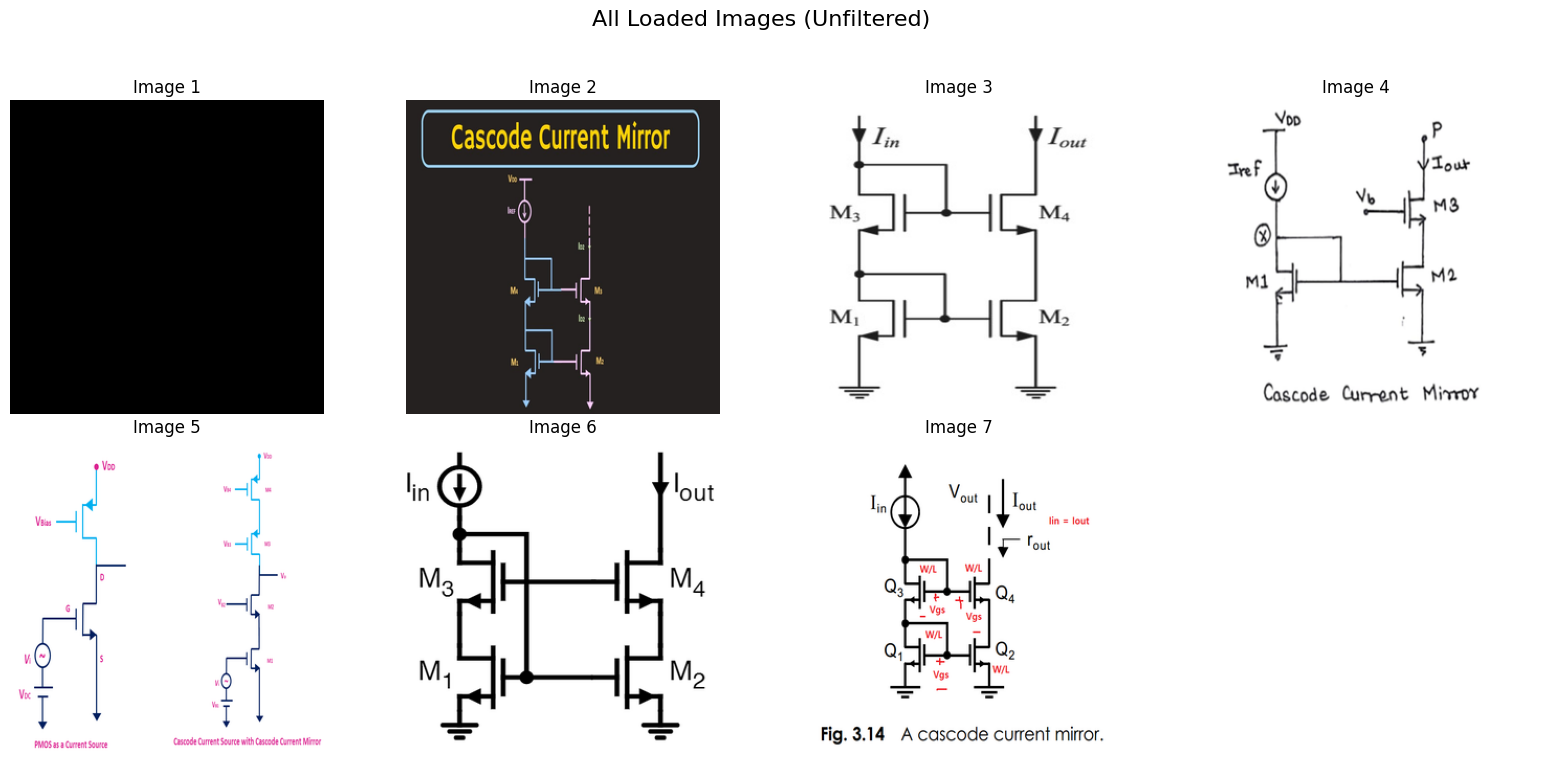


--- Step 3: Filtering to find the single best image ---
Displaying the single most representative image.


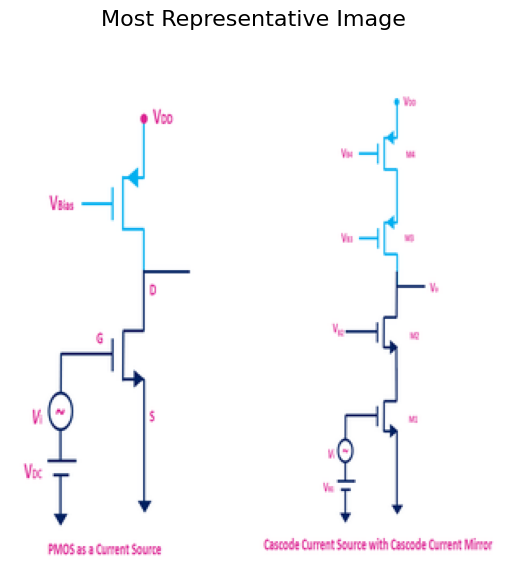

In [28]:
import asyncio
import nest_asyncio
import requests
import io
from simple_image_download import simple_image_download as simp
from PIL import Image
import matplotlib.pyplot as plt
import math
import numpy as np
from skimage.metrics import structural_similarity as ssim
import warnings

def find_most_representative_image(image_list, similarity_threshold=0.3):
    """
    Finds the largest cluster of similar images and returns only the single
    most representative image from that group.

    Args:
        image_list (list): A list of PIL Image objects.
        similarity_threshold (float): The minimum SSIM score to be considered similar.

    Returns:
        list: A list containing only the single most representative image, or an empty list.
    """
    if len(image_list) < 3:
        return image_list

    # Convert all images to grayscale numpy arrays for comparison
    gray_images = [np.array(img.convert('L')) for img in image_list]

    # Create a matrix to store similarity scores between images
    similarity_matrix = np.zeros((len(gray_images), len(gray_images)))

    for i in range(len(gray_images)):
        for j in range(i, len(gray_images)):
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", RuntimeWarning)
                    score = ssim(gray_images[i], gray_images[j], data_range=gray_images[i].max() - gray_images[i].min())
                similarity_matrix[i, j] = score
                similarity_matrix[j, i] = score
            except ValueError:
                similarity_matrix[i, j] = 0
                similarity_matrix[j, i] = 0

    # Find the largest group of mutually similar images
    largest_group_indices = []
    for i in range(len(image_list)):
        current_group_indices = [i]
        for j in range(len(image_list)):
            if i == j: continue
            if similarity_matrix[i, j] > similarity_threshold:
                current_group_indices.append(j)
        
        if len(current_group_indices) > len(largest_group_indices):
            largest_group_indices = current_group_indices

    if not largest_group_indices:
        return []

    # From the largest group, find the single most representative image
    group_similarity_matrix = similarity_matrix[np.ix_(largest_group_indices, largest_group_indices)]
    avg_similarity_in_group = np.mean(group_similarity_matrix, axis=1)
    most_representative_local_index = np.argmax(avg_similarity_in_group)
    
    # Get the original index of the best image
    final_image_index = largest_group_indices[most_representative_local_index]

    return [image_list[final_image_index]]

def fetch_and_display_images(query: str, limit: int = 10, resize_to: tuple = (300, 300)):
    """
    Fetches image URLs, displays all valid ones, then filters to show only
    the single most representative image.

    Args:
        query (str): The circuit to search for.
        limit (int): The number of images to fetch.
        resize_to (tuple): The (width, height) to resize the images to.
    """
    print(f"--- Step 1: Fetching {limit} image URLs for '{query}' ---")
    
    try:
        downloader = simp.simple_image_download()
        image_urls = downloader.urls(query, limit=limit)

        if not image_urls:
            print("Could not find any image URLs.")
            return

        print(f"\n--- Step 2: Loading and displaying all valid images ---")
        
        loaded_images = []
        for url in image_urls:
            try:
                response = requests.get(url, timeout=10)
                response.raise_for_status()
                img_data = io.BytesIO(response.content)
                img = Image.open(img_data).convert("RGB")
                img_resized = img.resize(resize_to, Image.Resampling.LANCZOS)
                loaded_images.append(img_resized)
            except Exception as e:
                print(f"Skipping image from URL {url}: {e}")
        
        if not loaded_images:
            print("No images could be successfully loaded.")
            return

        # Display all successfully loaded images
        cols = 4
        rows = math.ceil(len(loaded_images) / cols)
        fig1, axes1 = plt.subplots(rows, cols, figsize=(16, 4 * rows))
        fig1.suptitle('All Loaded Images (Unfiltered)', fontsize=16)
        axes1 = axes1.flatten()
        for i, img in enumerate(loaded_images):
            axes1[i].imshow(img)
            axes1[i].set_title(f"Image {i+1}")
            axes1[i].axis('off')
        for j in range(i + 1, len(axes1)):
            axes1[j].axis('off')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

        print(f"\n--- Step 3: Filtering to find the single best image ---")
        
        best_image_list = find_most_representative_image(loaded_images)
        
        if not best_image_list:
            print("Could not determine a representative image after filtering.")
            return
            
        print(f"Displaying the single most representative image.")
        
        # Display only the single best image
        best_image = best_image_list[0]
        fig2, ax2 = plt.subplots(figsize=(6, 6))
        fig2.suptitle('Most Representative Image', fontsize=16)
        ax2.imshow(best_image)
        ax2.axis('off')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    except Exception as e:
        print(f"An error occurred during image processing: {e}")


def main():
    """
    Main function to run the image retrieval process.
    """
    # You may need to install scikit-image: pip install scikit-image
    circuit_query = "cascode current mirror mosfet circuit"
    fetch_and_display_images(circuit_query, limit=10)

if __name__ == "__main__":
    nest_asyncio.apply()
    main()
